In [43]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing as pp
from sklearn import model_selection as ms 
from sklearn import linear_model as lm 
from sklearn import svm 
from sklearn import neighbors as knn
from sklearn import naive_bayes as nb 
from sklearn import metrics as m

import optuna
import joblib 

import time
import serial 
from IPython.display import clear_output
import os
import warnings

plt.style.use('bmh')
warnings.filterwarnings('ignore')

RS = 8 #random_state

# from copy import deepcopy
# import MotoricaInterface as mi; assert(mi.__version__=="0.0.3") # last time tested
# vp = mi.VirtualPhantomClient('localhost', 1755)

# IO Utils

### Data

In [44]:
datas = []

for dirname, _, filenames in os.walk('.\\temp'):
    for filename in filenames:
        datas.append(os.path.join(dirname, filename))

datas = list(filter(lambda x: True if 'protocol' not in x else False, datas))


data_names = []

for path in datas:    
    d_path = path.split('\\')[-1]
    
    data_names.append(d_path)


data_names

['2024-03-04_08-17-49.emg8',
 '2024-03-04_10-00-21.emg8',
 '2024-03-04_11-11-02.emg8']

In [45]:
palm_file = './temp/'+data_names[0]
gestures = pd.read_csv(palm_file, sep=' ', on_bad_lines='warn')

gestures = (gestures
            [~gestures['state'].isin(['Baseline', 'Finish'])]
            .sort_index()
            .reset_index(drop=True))

gestures

,ts,td,0,1,2,3,4,5,6,7,...,44,45,46,47,48,49,prot,state,id,now
0,96392.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.02
1,96425.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.05
2,96458.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.08
3,96491.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.12
4,96524.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6359,306239.0,33.0,372.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,10.0,160,Neutral,0,214.86
6360,306272.0,33.0,334.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,9.0,160,Neutral,0,214.90
6361,306305.0,33.0,301.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,160,Neutral,0,214.93
6362,306338.0,33.0,270.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,160,Neutral,0,214.96


In [46]:
OMG_CH = np.arange(50).astype(str)
X = gestures[OMG_CH]

X.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49'],
      dtype='object')

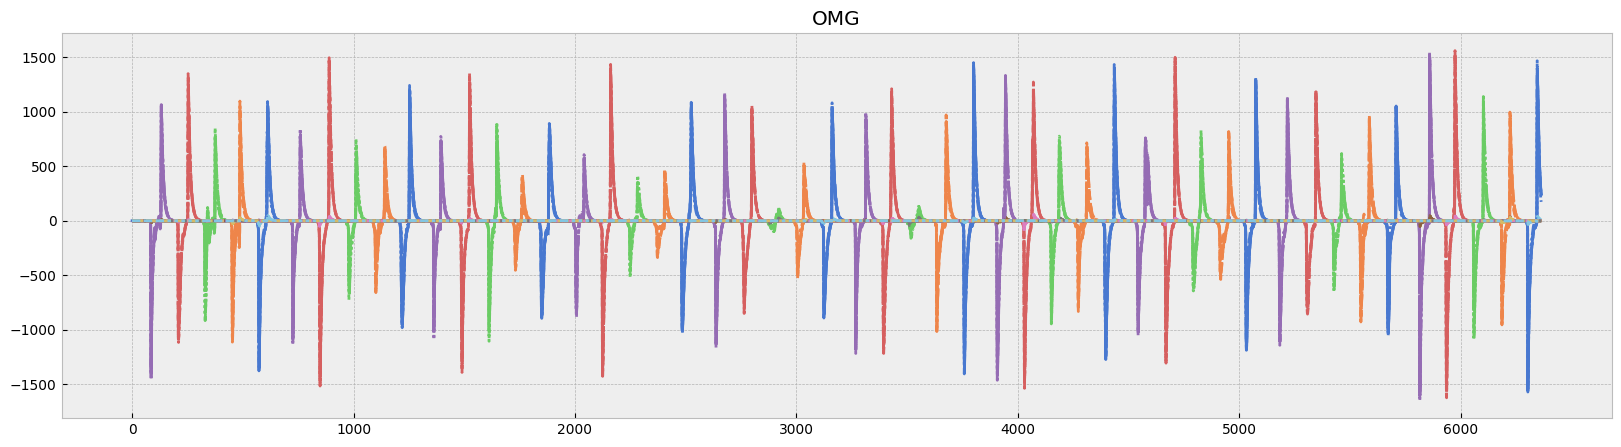

In [47]:
plt.figure(figsize=(20, 5))
sns.lineplot(X, legend=False, palette='muted')

plt.title('OMG')
plt.show()

### Target

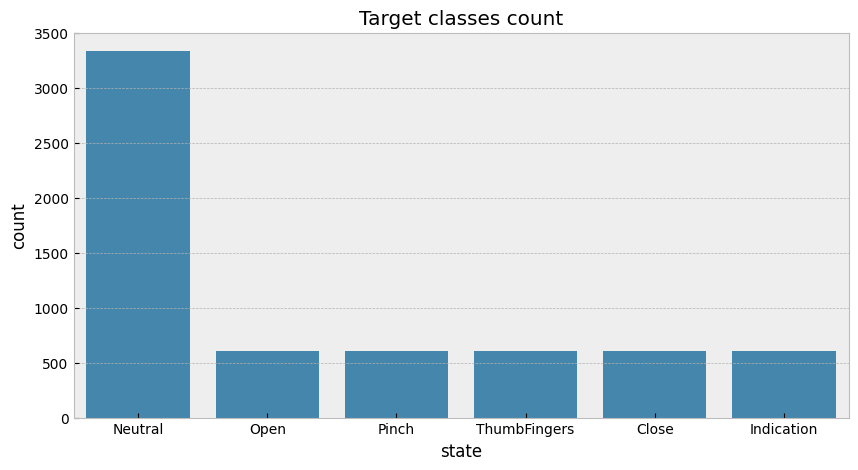

In [48]:
plt.figure(figsize=(10, 5))
sns.barplot(gestures['state'].value_counts())

plt.title('Target classes count')
plt.show()

In [49]:
le = pp.LabelEncoder()

state = gestures['state'].values
y = pd.Series(le.fit_transform(state), name='y')

np.c_[le.transform(le.classes_), le.classes_]

array([[0, 'Close'],
       [1, 'Indication'],
       [2, 'Neutral'],
       [3, 'Open'],
       [4, 'Pinch'],
       [5, 'ThumbFingers']], dtype=object)

In [50]:
GESTURES = le.classes_.tolist()
NUM_G = len(GESTURES)

GESTURES, NUM_G 

(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'], 6)

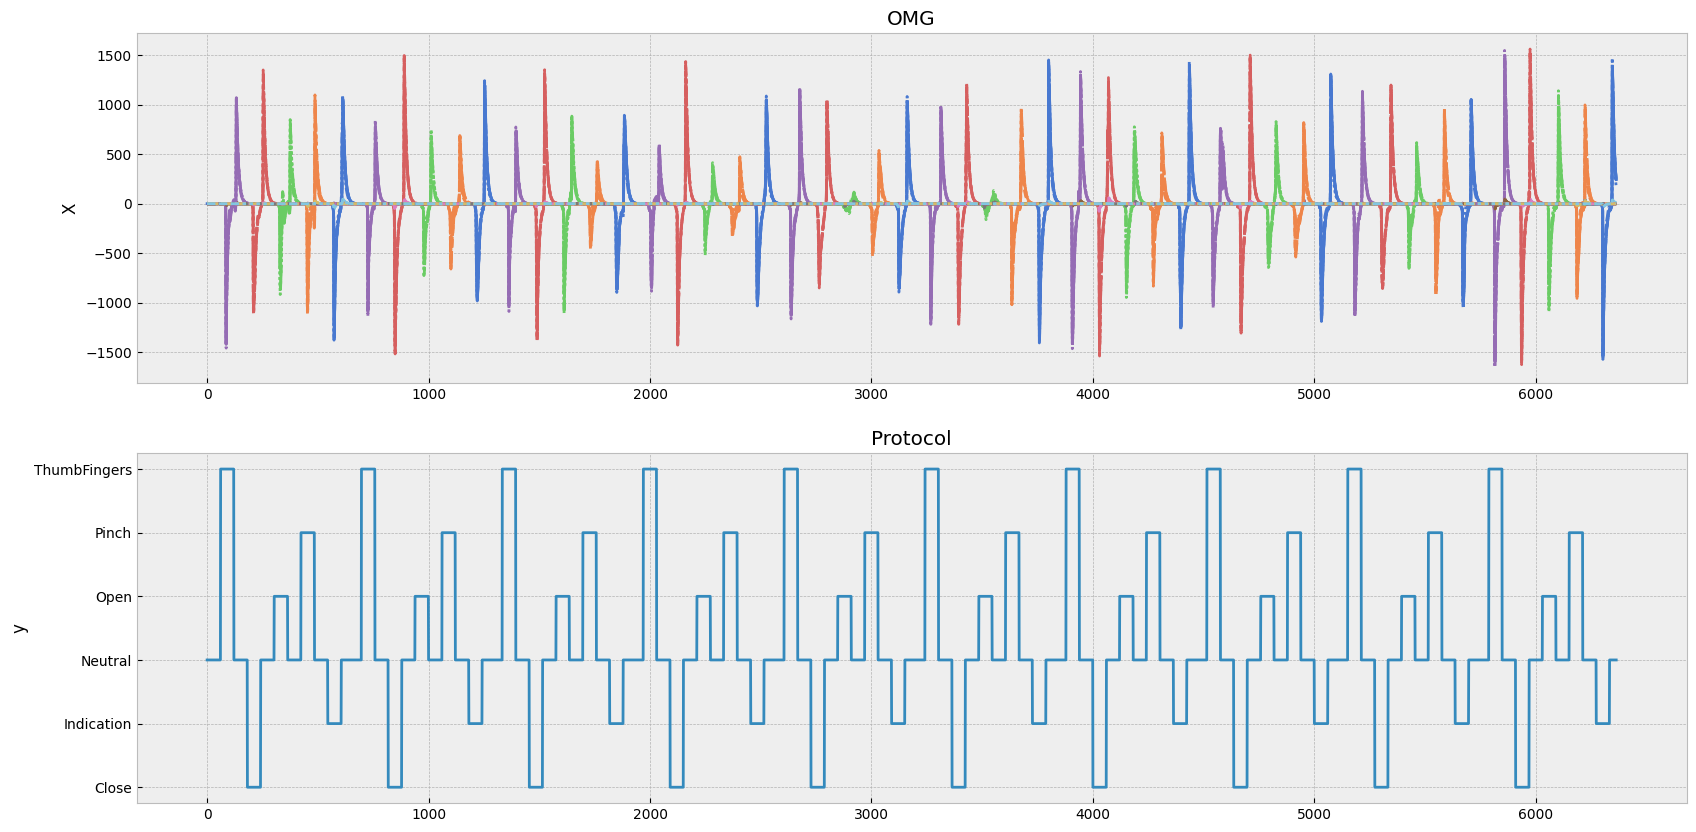

In [51]:
def show_omg_protocol(omg=X, protocol=y):
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    sns.lineplot(omg, legend=False, palette='muted', ax=ax[0])
    ax[0].set_title('OMG')
    ax[0].set_ylabel('X')

    sns.lineplot(protocol, ax=ax[1])
    ax[1].set_title('Protocol')
    ax[1].set_yticks(range(NUM_G), GESTURES)

    fig.show()
    

show_omg_protocol(X, y)

# Preprocessing

In [52]:
binarise_y = lambda x: 1 if x != 2 else 0


def get_temp(data):
    scaler = pp.StandardScaler()
    data_scaled = scaler.fit_transform(data) 
    
    temp = pd.DataFrame(
        data_scaled,
        columns=data.columns
    ).abs() 
    
    return temp

### Shifting

Best shifting value: 26


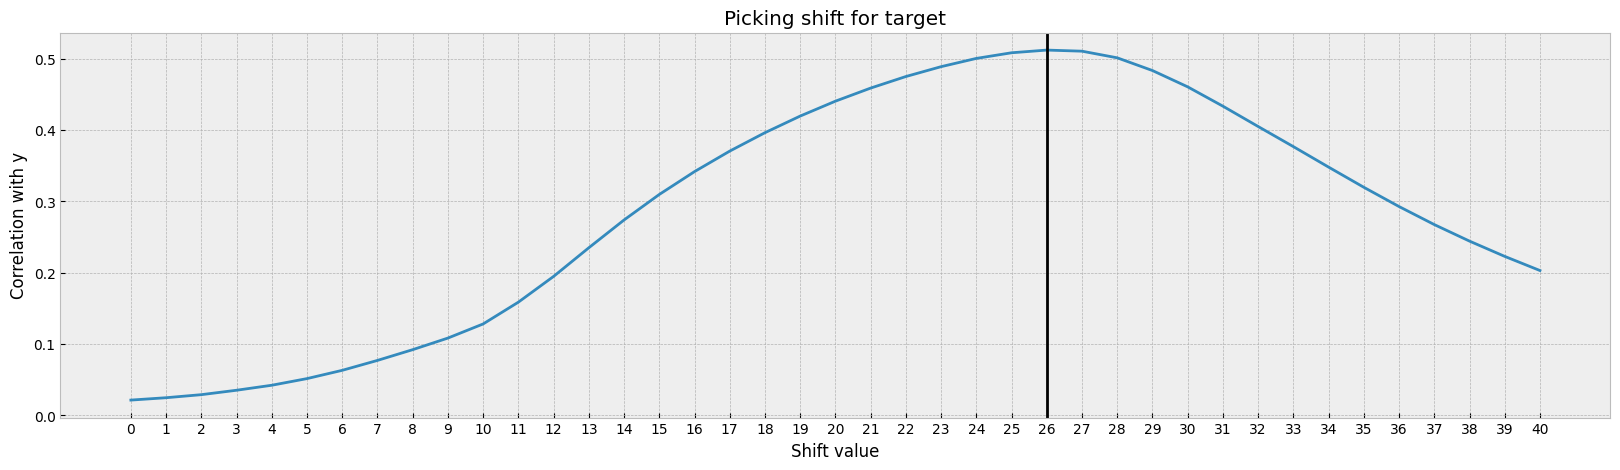

In [53]:
def select_shift(data, targ, plot=False):
    shift_corr = pd.Series() 
    
    disp = get_temp(data).sum(axis=1)
    t_bin = targ.apply(binarise_y)
    
    shift_range = range(41)
    for shift_value in shift_range:  
        shifted_y = (t_bin
                     .shift(shift_value)
                     .fillna(0))
        
        shift_corr.loc[shift_value] = disp.corr(shifted_y)
    
    best_shift = (shift_corr
                  .abs()
                  .sort_values(ascending=False)
                  .index[0])
    
    if plot:
        print('Best shifting value:', best_shift)
        
        plt.figure(figsize=(20, 5))
        sns.lineplot(shift_corr)

        plt.xticks(shift_range)
        plt.axvline(best_shift, color='black')
        
        plt.xlabel('Shift value')
        plt.ylabel('Correlation with y')
        plt.title('Picking shift for target')
        plt.show()
    
    return int(best_shift)


best_shift = select_shift(X, y, plot=True)

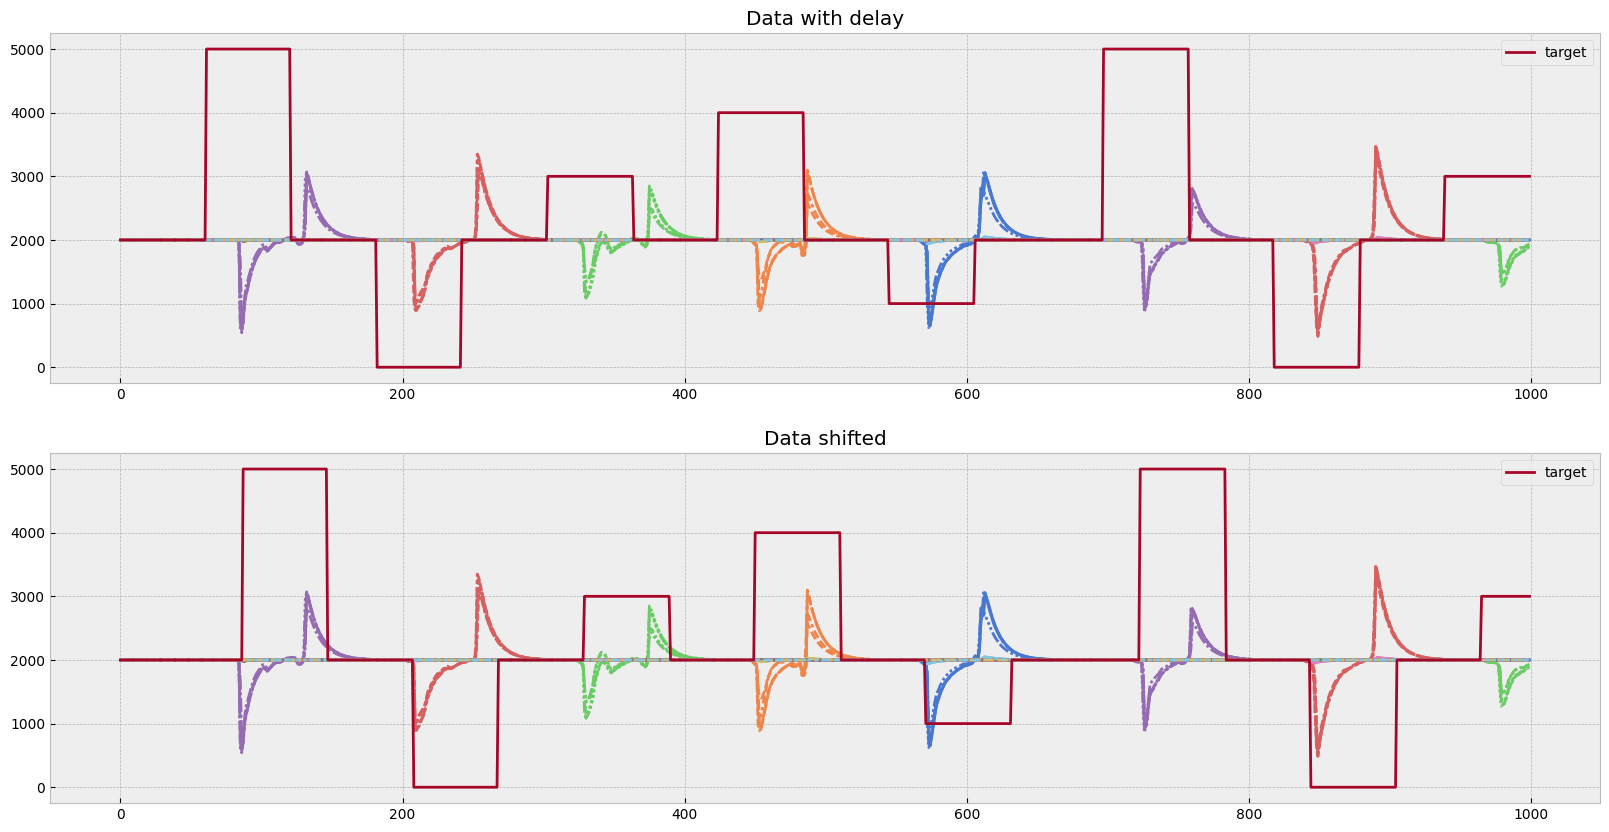

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(X.iloc[:1000] + 2000, 
             legend=False, 
             palette='muted', 
             ax=ax[0])
sns.lineplot(y.iloc[:1000] * 1000, 
             label='target', 
             ax=ax[0])
ax[0].set_title('Data with delay')
ax[0].set_ylabel('')


shift_targ = lambda targ, shift: pd.Series(targ).shift(shift).fillna(2)
y_shifted = shift_targ(y, best_shift)

sns.lineplot(X.iloc[:1000] + 2000, 
             legend=False, 
             palette='muted', 
             ax=ax[1])
sns.lineplot(y_shifted.iloc[:1000] * 1000, 
             label='target', 
             ax=ax[1])
ax[1].set_title('Data shifted')
ax[1].set_ylabel('')


fig.show()

### Smoothing

Best window value: 9


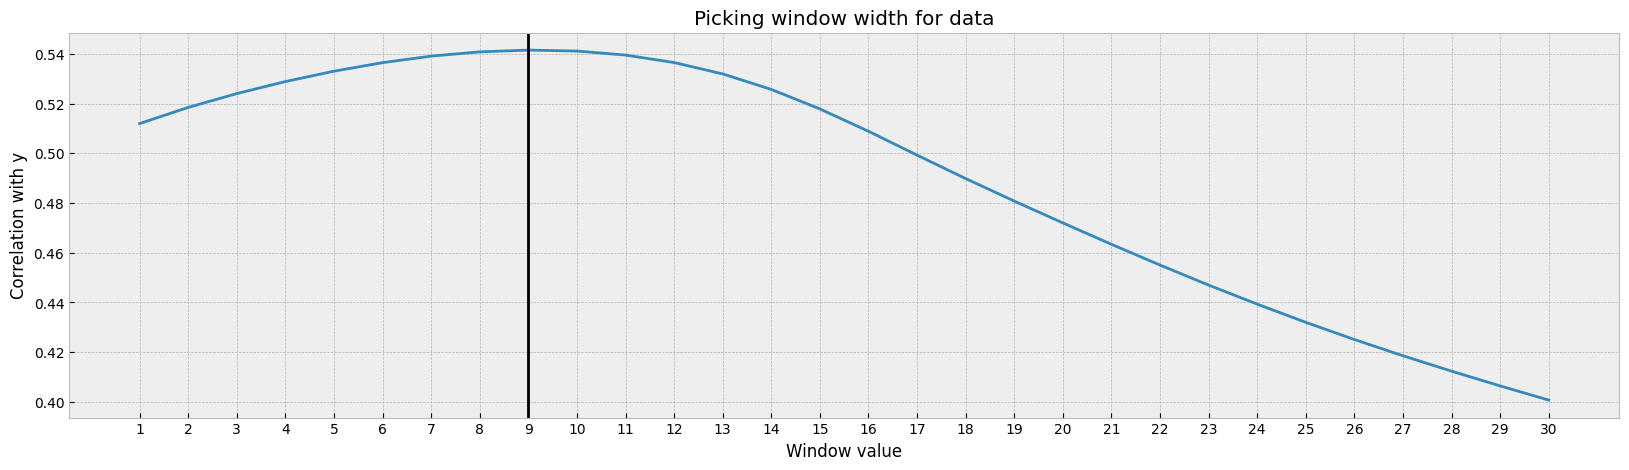

In [55]:
def select_window(data, targ, plot=False):
    smooth_corr = pd.Series()
    
    t_bin = targ.apply(binarise_y)
    temp = get_temp(data) 

    win_range = range(1, 31)
    for win_value in win_range:      
        smoothed_temp = (temp
                         .rolling(win_value, 1)
                         .mean())
        smoothed_disp = smoothed_temp.sum(axis=1)
        
        smooth_corr.loc[win_value] = smoothed_disp.corr(t_bin)
        
    best_win = smooth_corr.sort_values(ascending=False).index[0]
    
    if plot:
        print('Best window value:', best_win)
        
        plt.figure(figsize=(20, 5))
        sns.lineplot(smooth_corr)
        
        plt.xticks(win_range)
        plt.axvline(best_win, color='black')
        
        plt.xlabel('Window value')
        plt.ylabel('Correlation with y')
        plt.title('Picking window width for data')
        plt.show()
    
    return int(best_win)


best_win = select_window(X, y_shifted, plot=True)

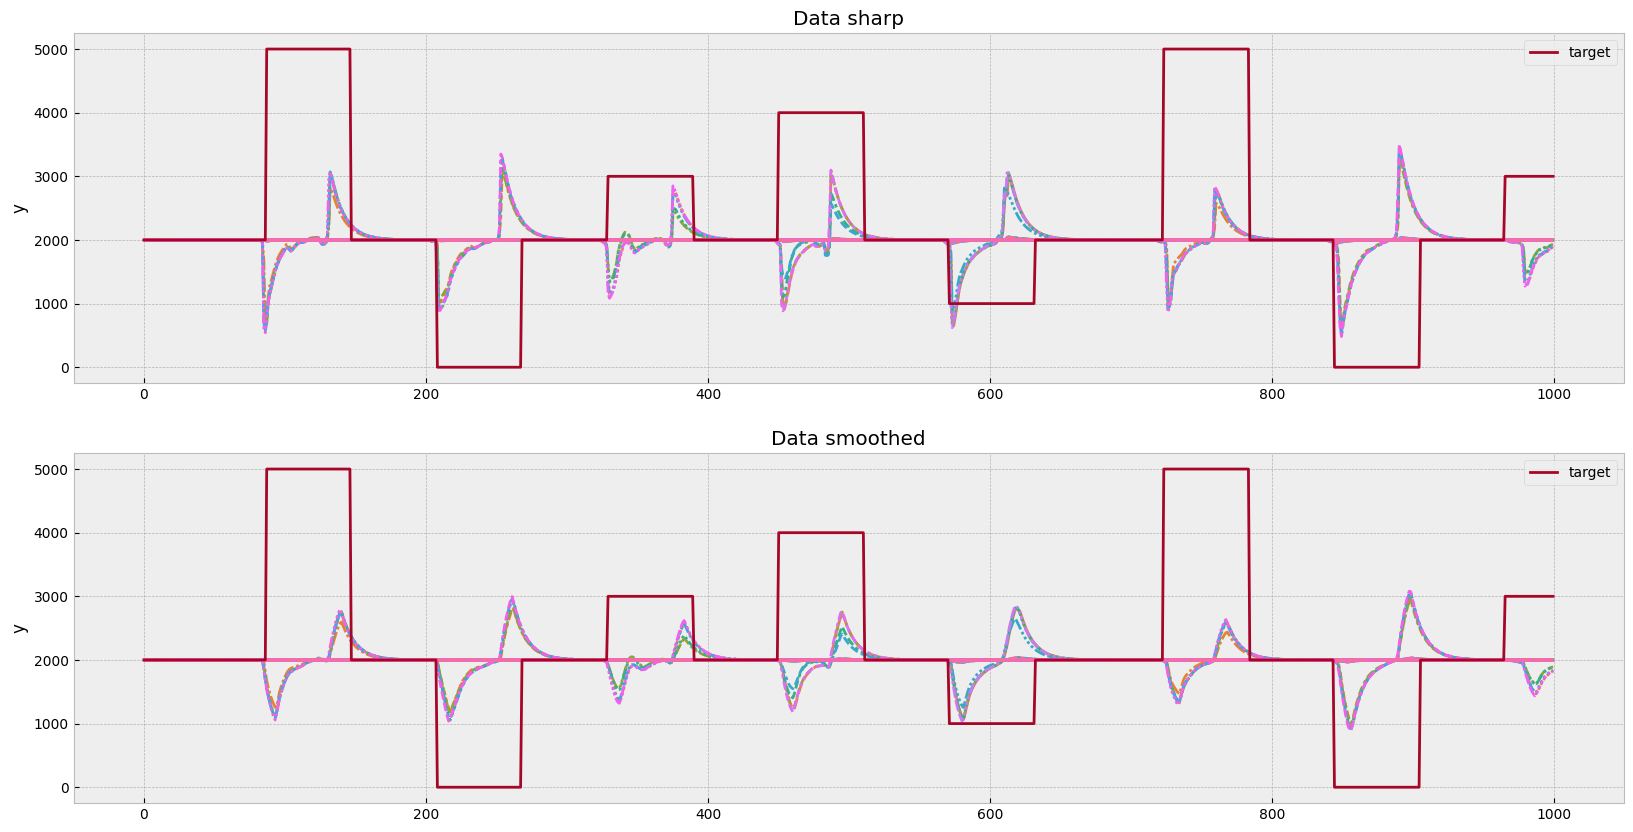

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(X.iloc[:1000] + 2000, 
             legend=False, 
             ax=ax[0])
sns.lineplot(y_shifted.iloc[:1000] * 1000, 
             label='target', 
             ax=ax[0])
ax[0].set_title('Data sharp')


smoothe_data = lambda X, win: pd.DataFrame(X).rolling(win, 1).mean()
X_smoothed = smoothe_data(X, best_win)

sns.lineplot(X_smoothed.iloc[:1000] + 2000, 
             legend=False, 
             ax=ax[1])
sns.lineplot(y_shifted.iloc[:1000] * 1000, 
             label='target', 
             ax=ax[1])
ax[1].set_title('Data smoothed')


fig.show()

### Train-Test split

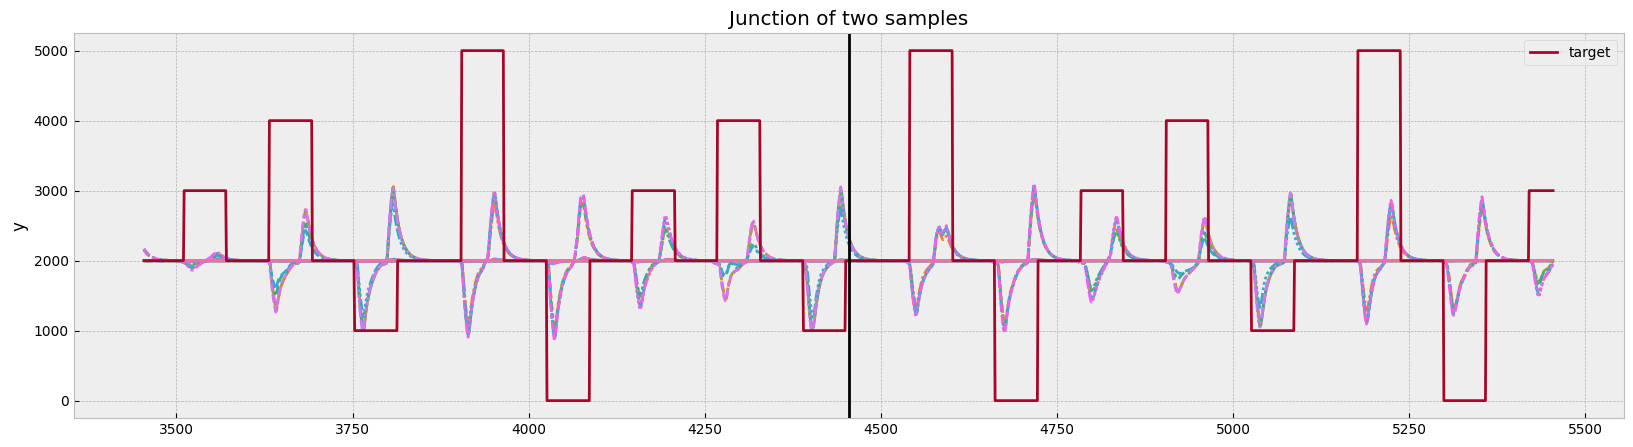

In [57]:
pd_concat = lambda d1, d2: pd.concat([d1, d2], axis=0, ignore_index=True)
data_junction = lambda X, split_i, bound=1000: X.loc[split_i-bound : split_i+bound]


X_train, X_test, y_train, y_test = ms.train_test_split(
    X_smoothed, 
    y_shifted, 
    test_size = 0.3, 
    shuffle = False,
    random_state = RS
)


X_2 = pd_concat(X_train, X_test) + 2000
y_2 = pd_concat(y_train, y_test) * 1000
last_train_i = X_train.shape[0]

plt.figure(figsize=(20, 5))
sns.lineplot(data_junction(X_2, last_train_i), legend=False)
sns.lineplot(data_junction(y_2, last_train_i), label='target')

plt.axvline(last_train_i, color='black')
plt.title('Junction of two samples')
plt.show() 

### Scaling

In [58]:
scaler = pp.StandardScaler()


def scale_data(X_train, X_test, scaler=scaler):
    COLS = X_train.columns
    scaler.fit(X_train)

    X_train_scaled = pd.DataFrame(
        scaler.transform(X_train), 
        columns=COLS
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=COLS
    )
    
    return X_train_scaled, X_test_scaled

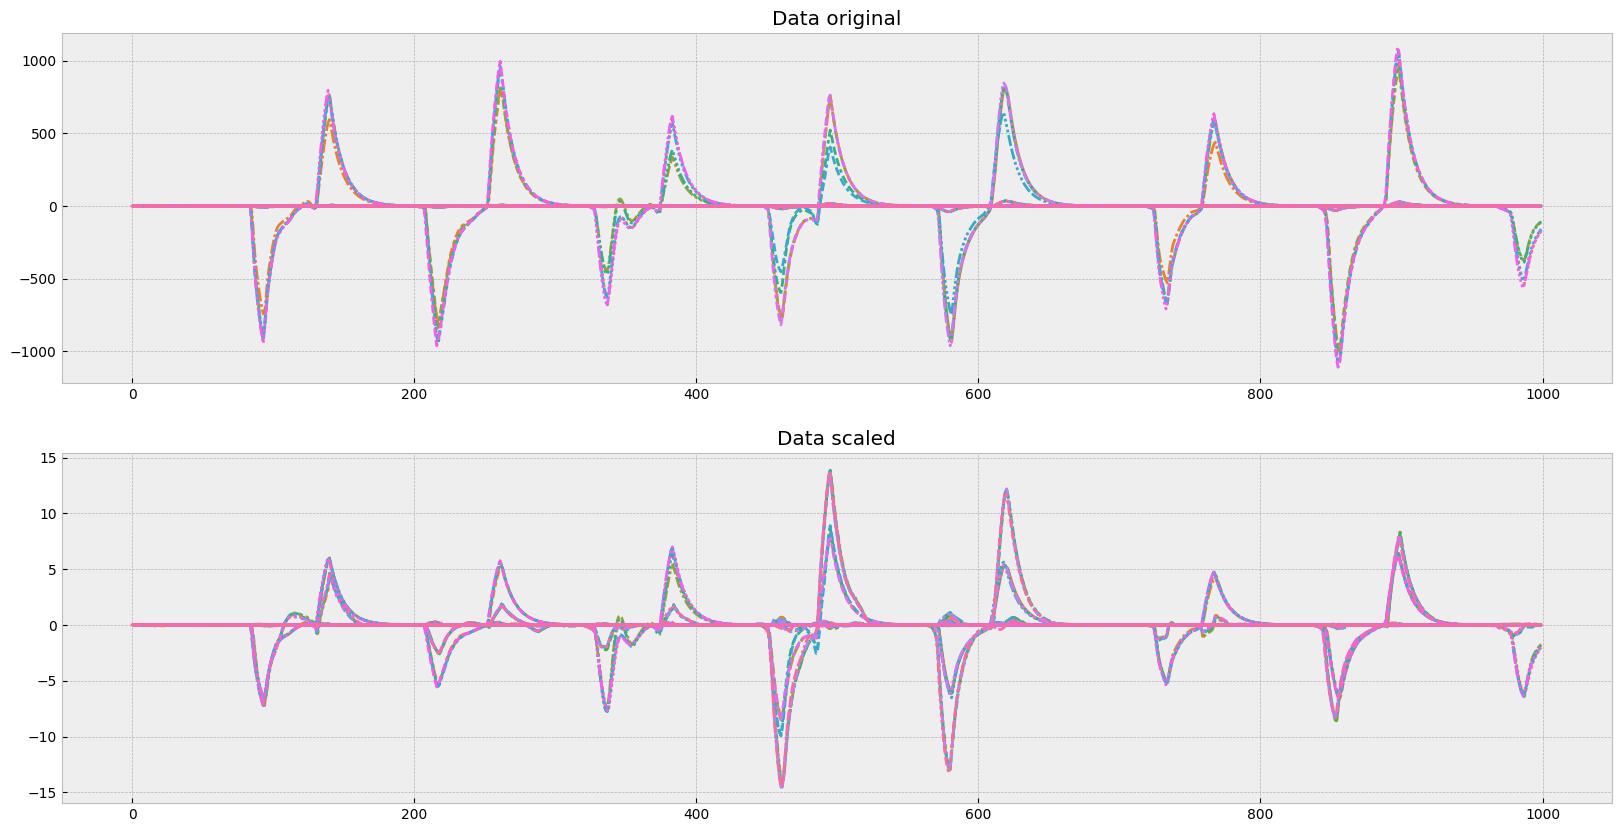

In [59]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(X_train.iloc[:1000], 
             legend=False, 
             ax=ax[0])
ax[0].set_title('Data original')


X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

sns.lineplot(X_train_scaled.iloc[:1000], 
             legend=False, 
             ax=ax[1])
ax[1].set_title('Data scaled')

fig.show() 

# Modeling

### Model selection

In [60]:
def model_score(model, Xy_set, sample=('train', 'test'), fitted=True):    
    if sample == 'train':
        X, y = Xy_set[0], Xy_set[2]
    elif sample == 'test':
        X, y = Xy_set[1], Xy_set[3]
    else:
        raise ValueError('No such sample')
    
    if not fitted:
        model.fit(Xy_set[0], Xy_set[2])
    
    y_ = model.predict(X)
    score = m.f1_score(y, y_, average='macro') * 100
    
    return float(score) if len(set(y_)) == NUM_G else 0

Session with Logistic Regression is done.
Session with Stochastic Gradient Descend is done.
Session with Support Vector Machine is done.
Session with Nearest Neighbors is done.
Session with Passive Aggressive is done.
Session with Naive Bayes is done.


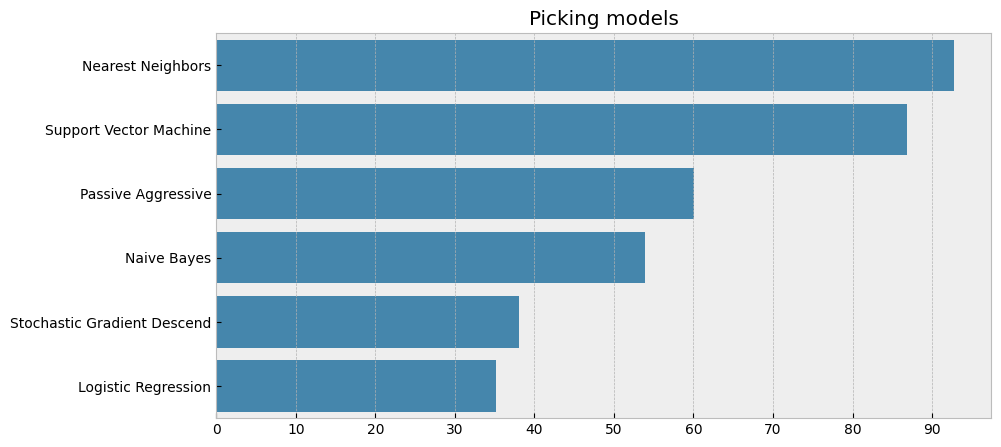

In [61]:
models = {
    'Logistic Regression': lm.LogisticRegression(random_state=RS), 
    'Stochastic Gradient Descend': lm.SGDClassifier(random_state=RS), 
    'Support Vector Machine': svm.SVC(random_state=RS), 
    'Nearest Neighbors': knn.KNeighborsClassifier(), 
    'Passive Aggressive': lm.PassiveAggressiveClassifier(random_state=RS), 
    'Naive Bayes': nb.GaussianNB()
}

Xy_set = (X_train_scaled, X_test_scaled, y_train, y_test)


model_scores = pd.Series()

for name, model in models.items():    
    model_scores.loc[name] = model_score(model, Xy_set, 'test', False)
    
    print(f'Session with {name} is done.')

model_scores.sort_values(ascending=False, inplace=True)


plt.figure(figsize=(10, 5))
sns.barplot(model_scores, orient='h')

plt.xticks(range(0, 100, 10))
plt.title('Picking models')
plt.show()

In [62]:
BASELINE_SCORE = model_scores.iloc[0]

BASELINE_SCORE

92.79180672530912

### Metrics

In [63]:
def get_f1(y, y_, sample):
    class_report = m.classification_report(
        y, y_, 
        target_names=GESTURES, 
        output_dict=True
    )
    
    scores_df = (
        pd.DataFrame(class_report)
        .loc['f1-score']
        #.drop(['accuracy', 'weighted avg'], axis=0)
        .mul(100)
        .rename(sample)
    )
    
    return scores_df
    

def model_report(model, Xy_set, fitted=False):
    # FIT & PREDICT
    X_train, X_test, y_train, y_test = Xy_set
    
    if not fitted:
        model.fit(X_train, y_train)
        
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # EVALUATE
    nunq = lambda a: len(np.unique(a))
    
    if ((nunq(y_pred_train) != NUM_G) or
        (nunq(y_pred_test) != NUM_G)):
        raise ValueError('Bad prediction')
    
    train_f1_gest = get_f1(y_train, y_pred_train, 'train')
    test_f1_gest = get_f1(y_test, y_pred_test, 'test')
    
    scores = pd.concat([train_f1_gest, test_f1_gest], axis=1)
    
    y_train_df = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})
    y_test_df = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})
    
    # VISUALISE
    fig, ax = plt.subplots(3, 1, figsize=(20, 15))
    
    sns.lineplot(scores, markers=True, ax=ax[0])
    ax[0].axvline('macro avg', color='green')
    ax[0].axhline(100, color='black')
    ax[0].axhline(90, color='black')
    ax[0].set_title('Scores')
    
    sns.lineplot(y_train_df, ax=ax[1])
    ax[1].set_yticks(range(NUM_G), GESTURES)
    ax[1].set_title('Train')

    sns.lineplot(y_test_df, ax=ax[2])
    ax[2].set_yticks(range(NUM_G), GESTURES)
    ax[2].set_title('Test')

    fig.show()   

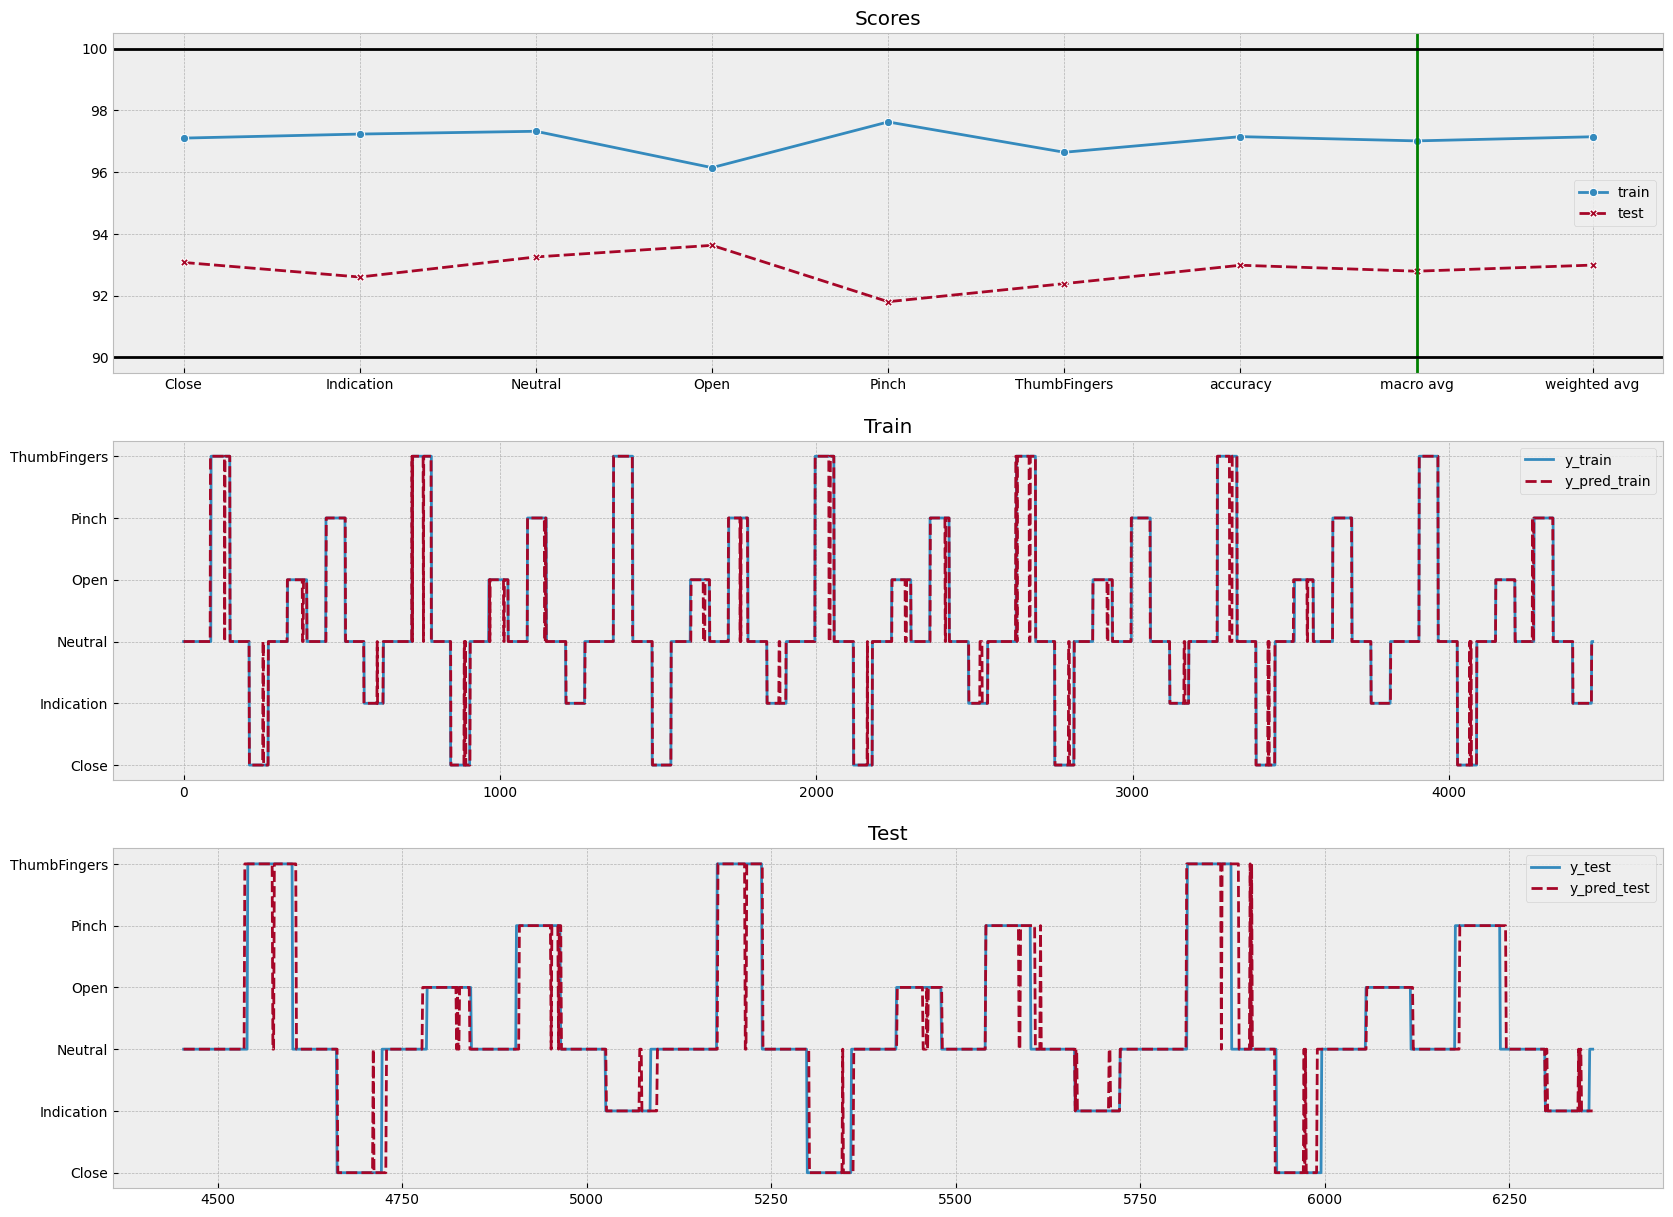

In [64]:
model = knn.KNeighborsClassifier()

model_report(model, Xy_set) 

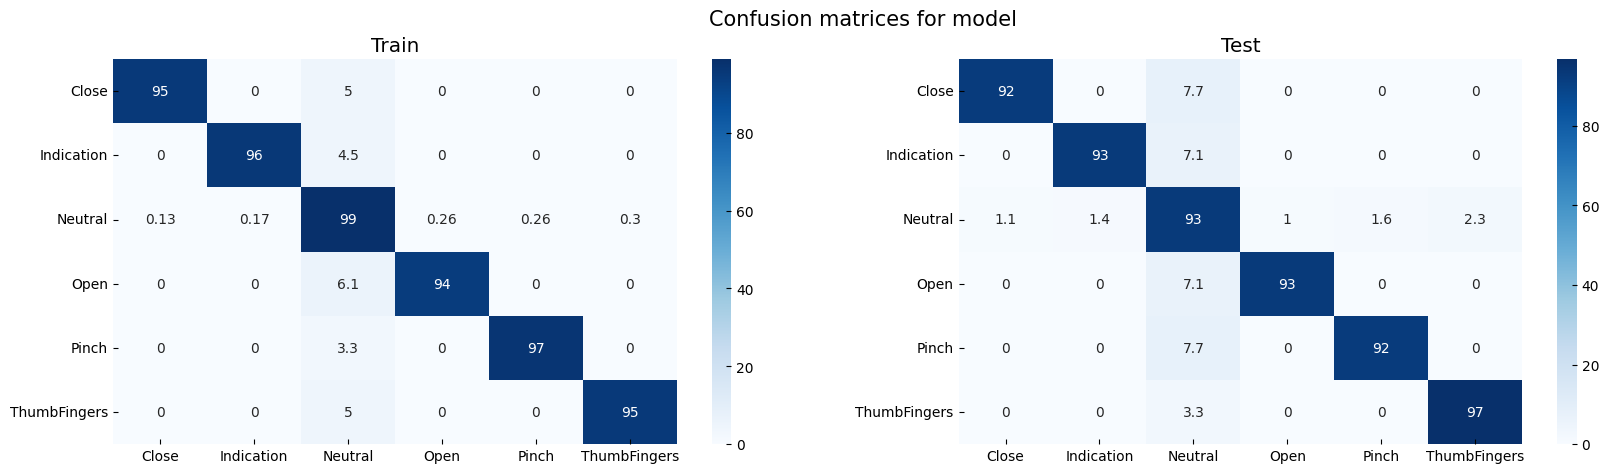

In [65]:
def show_confusion_matrix(model, Xy_set):
    X_train, X_test, y_train, y_test = Xy_set
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    cm_train = m.confusion_matrix(y_train, 
                                  y_pred_train, 
                                  normalize='true')*100
    cm_test = m.confusion_matrix(y_test, 
                                 y_pred_test, 
                                 normalize='true')*100
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    sns.heatmap(cm_train.round(2), 
                xticklabels=GESTURES, yticklabels=GESTURES,
                cmap='Blues', annot=True, ax=ax[0])
    ax[0].set_title('Train')
    
    sns.heatmap(cm_test.round(2), 
                xticklabels=GESTURES, yticklabels=GESTURES,
                cmap='Blues', annot=True, ax=ax[1])
    ax[1].set_title('Test')
    
    fig.suptitle('Confusion matrices for model', fontsize=15)
    fig.show()
    

show_confusion_matrix(model, Xy_set)

### *Multiple datasets

In [66]:
def read_omg_files(data_name):
    palm_file = './temp/'+data_name
    gestures = pd.read_csv(palm_file, sep=' ', on_bad_lines='warn')
    
    gestures = (gestures
                [~gestures['state'].isin(['Baseline', 'Finish'])]
                .sort_index()
                .reset_index(drop=True))
    
    OMG_CH = np.arange(50).astype(str)
    X = gestures[OMG_CH]

    le = pp.LabelEncoder()

    state = gestures['state'].values
    y = pd.Series(le.fit_transform(state), name='y')

    return X, y

In [68]:
data_scores = pd.DataFrame(
    columns=['score', 
             'shift', 
             'window', 
             'train_size', 
             'test_size']
)


for temp in data_names:
    X, y = read_omg_files(temp)
    X_omg = X[OMG_CH]
    
    shift = select_shift(X_omg, y)
    y_sh = shift_targ(y, shift)
    data_scores.loc[temp, 'shift'] = shift
    
    window = select_window(X_omg, y_sh)
    X_sm = smoothe_data(X_omg, window)
    data_scores.loc[temp, 'window'] = window
    
    Xa, Xb, ya, yb = ms.train_test_split(
        X_sm, 
        y_sh, 
        test_size = 0.3, 
        shuffle = False,
        random_state = RS
    )
    data_scores.loc[temp, 'train_size'] = Xa.shape[0]
    data_scores.loc[temp, 'test_size'] = Xb.shape[0]
    
    Xa_s, Xb_s = scale_data(Xa, Xb)
    
    data_scores.loc[temp, 'score'] = model_score(
        model, 
        (Xa_s, Xb_s, ya, yb), 
        'test'
    )
    
    
data_scores.sort_values('score', ascending=False, inplace=True)

data_scores 

Skipping line 3: expected 56 fields, saw 74



,score,shift,window,train_size,test_size
2024-03-04_08-17-49.emg8,92.791807,26,9,4454,1910
2024-03-04_11-11-02.emg8,64.591811,18,9,1781,764
2024-03-04_10-00-21.emg8,18.419441,17,3,4454,1910


### Feature selection

Session with 50 features is done.
Session with 49 features is done.
Session with 48 features is done.
Session with 47 features is done.
Session with 46 features is done.
Session with 45 features is done.
Session with 44 features is done.
Session with 43 features is done.
Session with 42 features is done.
Session with 41 features is done.
Session with 40 features is done.
Session with 39 features is done.
Session with 38 features is done.
Session with 37 features is done.
Session with 36 features is done.
Session with 35 features is done.
Session with 34 features is done.
Session with 33 features is done.
Session with 32 features is done.
Session with 31 features is done.
Session with 30 features is done.
Session with 29 features is done.
Session with 28 features is done.
Session with 27 features is done.
Session with 26 features is done.
Session with 25 features is done.
Session with 24 features is done.
Session with 23 features is done.
Session with 22 features is done.
Session with 2

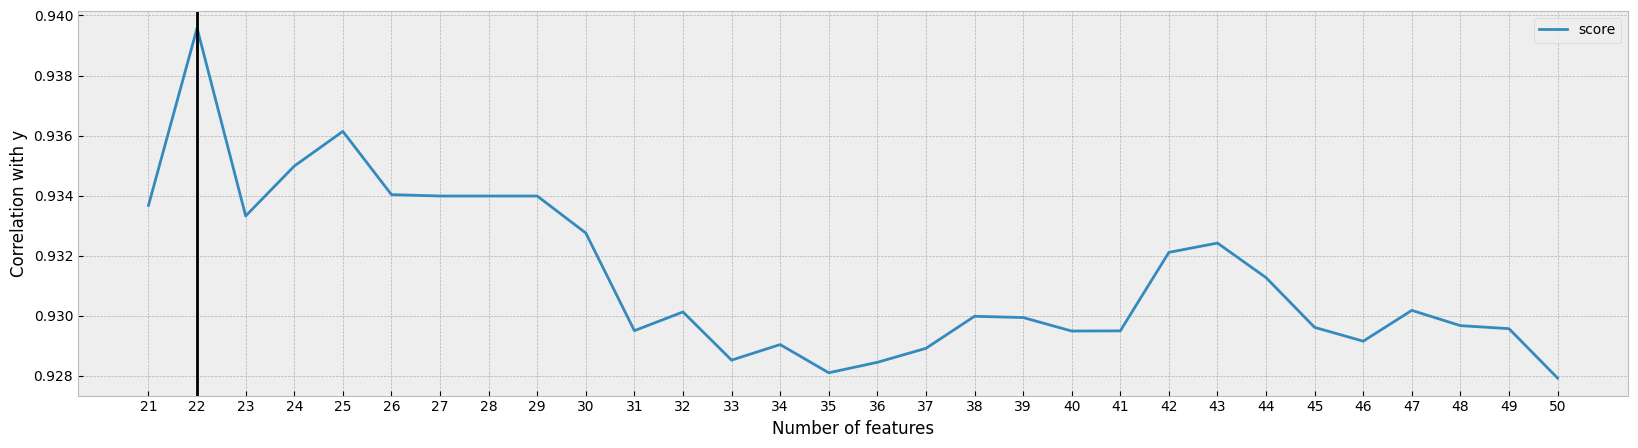

In [26]:
def select_features(Xy_set, model=model, plot=False):
    X_train, X_test, y_train, y_test = Xy_set
    
    noise_corr = pd.Series()
    y_bin = y_train.apply(binarise_y)

    for col in X_train.columns:    
        correlation = X_train[col].corr(y_bin)
        noise_corr.loc[col] = abs(correlation)

    noise_corr.sort_values(ascending=False, inplace=True)

    feature_scores = pd.DataFrame(columns=['features', 'score'])
    n_feats = noise_corr.shape[0]
    
    while n_feats > 0:
        features = noise_corr.iloc[:n_feats].index
        
        X_train_ = X_train.loc[:, features]
        X_test_ = X_test.loc[:, features]
        
        model.fit(X_train_, y_train)
        y_pred = model.predict(X_test_)
        
        score = m.f1_score(y_test, y_pred, average='macro')
        
        if score < 0.9:
            break
        else:
            feature_scores.loc[n_feats, 'features'] = features
            feature_scores.loc[n_feats, 'score'] = score
            
            print(f'Session with {n_feats} features is done.')
            n_feats -= 1
        
    best_features = (feature_scores
                     .sort_values('score', ascending=False)
                     .iloc[0, 0])
    
    if plot:
        print(f'\nBest {len(best_features)} features: \n{best_features}')
        
        plt.figure(figsize=(20, 5))
        sns.lineplot(feature_scores)
        
        plt.xticks(np.arange(n_feats, noise_corr.shape[0])+1)
        plt.axvline(len(best_features), color='black')
        
        plt.xlabel('Number of features')
        plt.ylabel('Correlation with y')
        plt.show()
    
    return list(best_features)


best_features = select_features(Xy_set, plot=True)

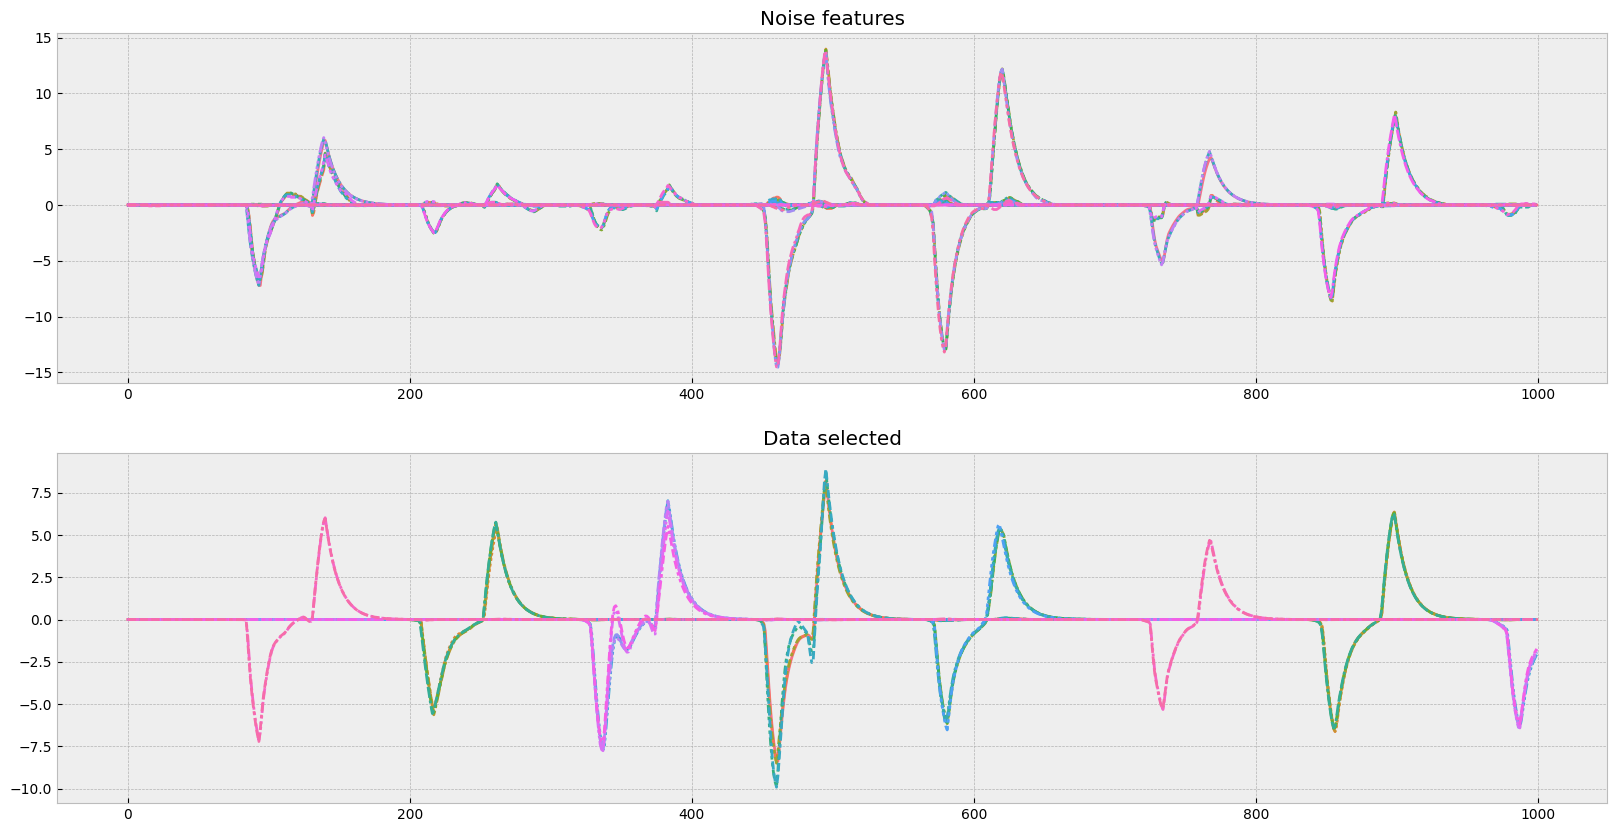

In [27]:
noisy_cols = (X_train_scaled
              .drop(best_features, axis=1)
              .columns)


fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(X_train_scaled.iloc[:1000][noisy_cols], 
             legend=False, 
             ax=ax[0])
ax[0].set_title('Noise features')


X_train_selected = X_train_scaled[best_features]
X_test_selected = X_test_scaled[best_features]

sns.lineplot(X_train_selected.iloc[:1000], 
             legend=False, 
             ax=ax[1])
ax[1].set_title('Data selected')


fig.show()

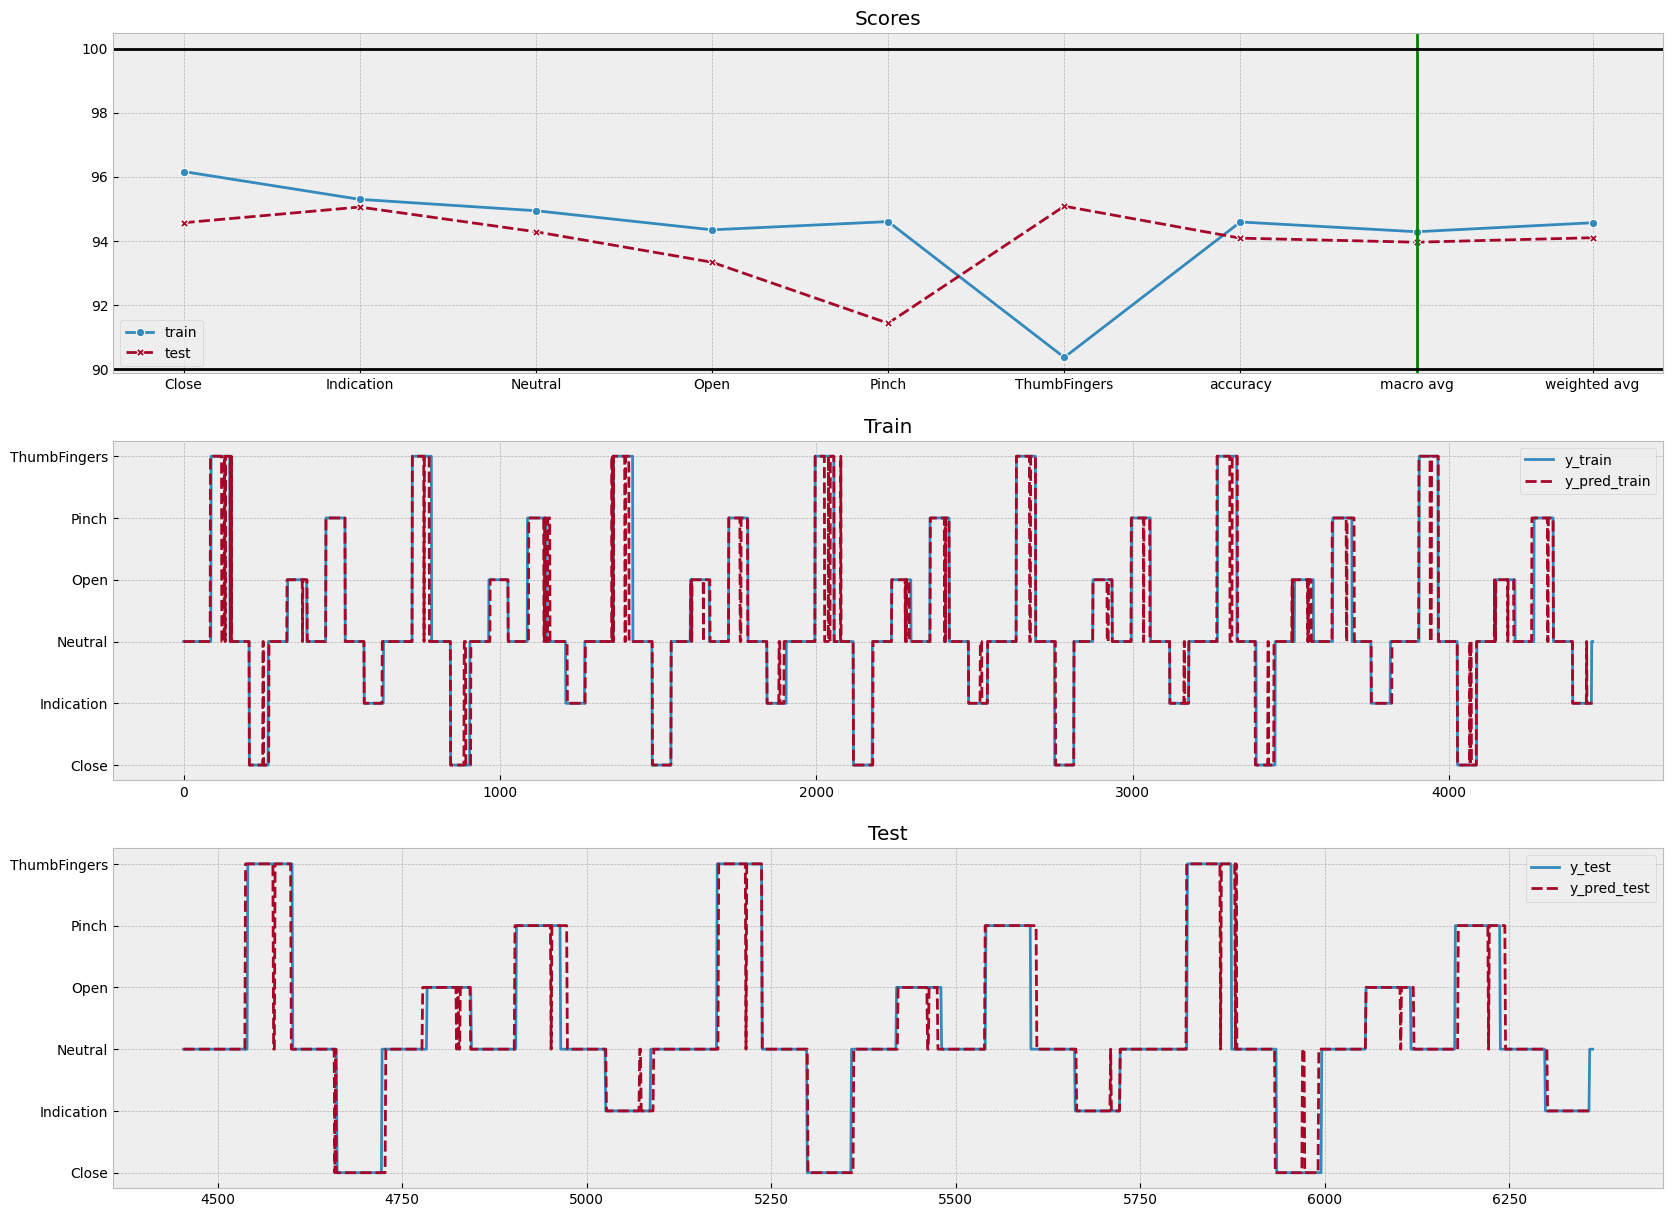

In [28]:
Xy_set_2 = (X_train_selected, 
            X_test_selected, 
            y_train, 
            y_test)

model_report(model, Xy_set_2)

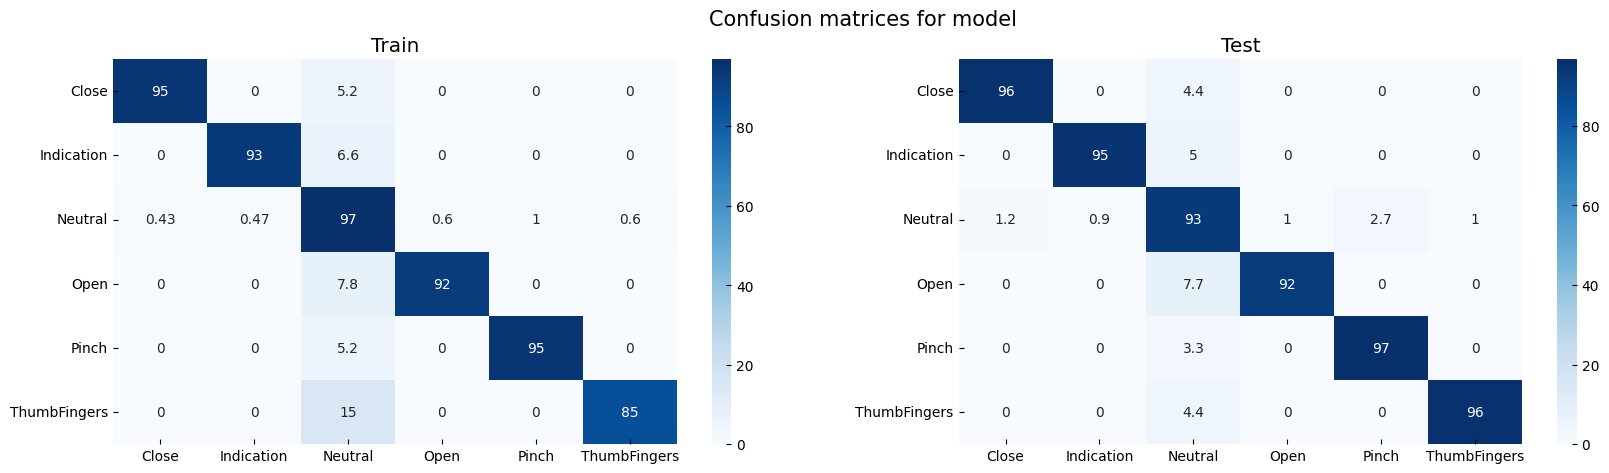

In [29]:
show_confusion_matrix(model, Xy_set_2)

### Optimisation

In [30]:
def opt_kneighbors(trial: optuna.trial.Trial):
    model.set_params(
        n_neighbors = trial.suggest_int('n_neighbors', 1, 20),
        p = trial.suggest_int('p', 1, 10)
    ).fit(
        X_train_selected, 
        y_train
    )
    
    train_score = model_score(model, Xy_set_2, 'train')
    test_score = model_score(model, Xy_set_2, 'test')
    
    return test_score if train_score != 100 else 0


knn_study = optuna.create_study(study_name='KNeighbors', direction='maximize')
knn_study.optimize(opt_kneighbors, n_trials=50)

print(f'\nBest params for KNeighbors:\n{knn_study.best_params}')

[I 2024-03-09 18:16:13,411] A new study created in memory with name: KNeighbors
[I 2024-03-09 18:16:15,379] Trial 0 finished with value: 92.77519820198815 and parameters: {'n_neighbors': 20, 'p': 6}. Best is trial 0 with value: 92.77519820198815.
[I 2024-03-09 18:16:17,366] Trial 1 finished with value: 93.2079078701413 and parameters: {'n_neighbors': 10, 'p': 6}. Best is trial 1 with value: 93.2079078701413.
[I 2024-03-09 18:16:19,295] Trial 2 finished with value: 93.79182624173508 and parameters: {'n_neighbors': 4, 'p': 9}. Best is trial 2 with value: 93.79182624173508.
[I 2024-03-09 18:16:21,260] Trial 3 finished with value: 92.84160244040821 and parameters: {'n_neighbors': 13, 'p': 4}. Best is trial 2 with value: 93.79182624173508.
[I 2024-03-09 18:16:23,190] Trial 4 finished with value: 92.8758805345967 and parameters: {'n_neighbors': 17, 'p': 7}. Best is trial 2 with value: 93.79182624173508.
[I 2024-03-09 18:16:25,210] Trial 5 finished with value: 92.99169563725654 and parameters


Best params for KNeighbors:
{'n_neighbors': 3, 'p': 6}


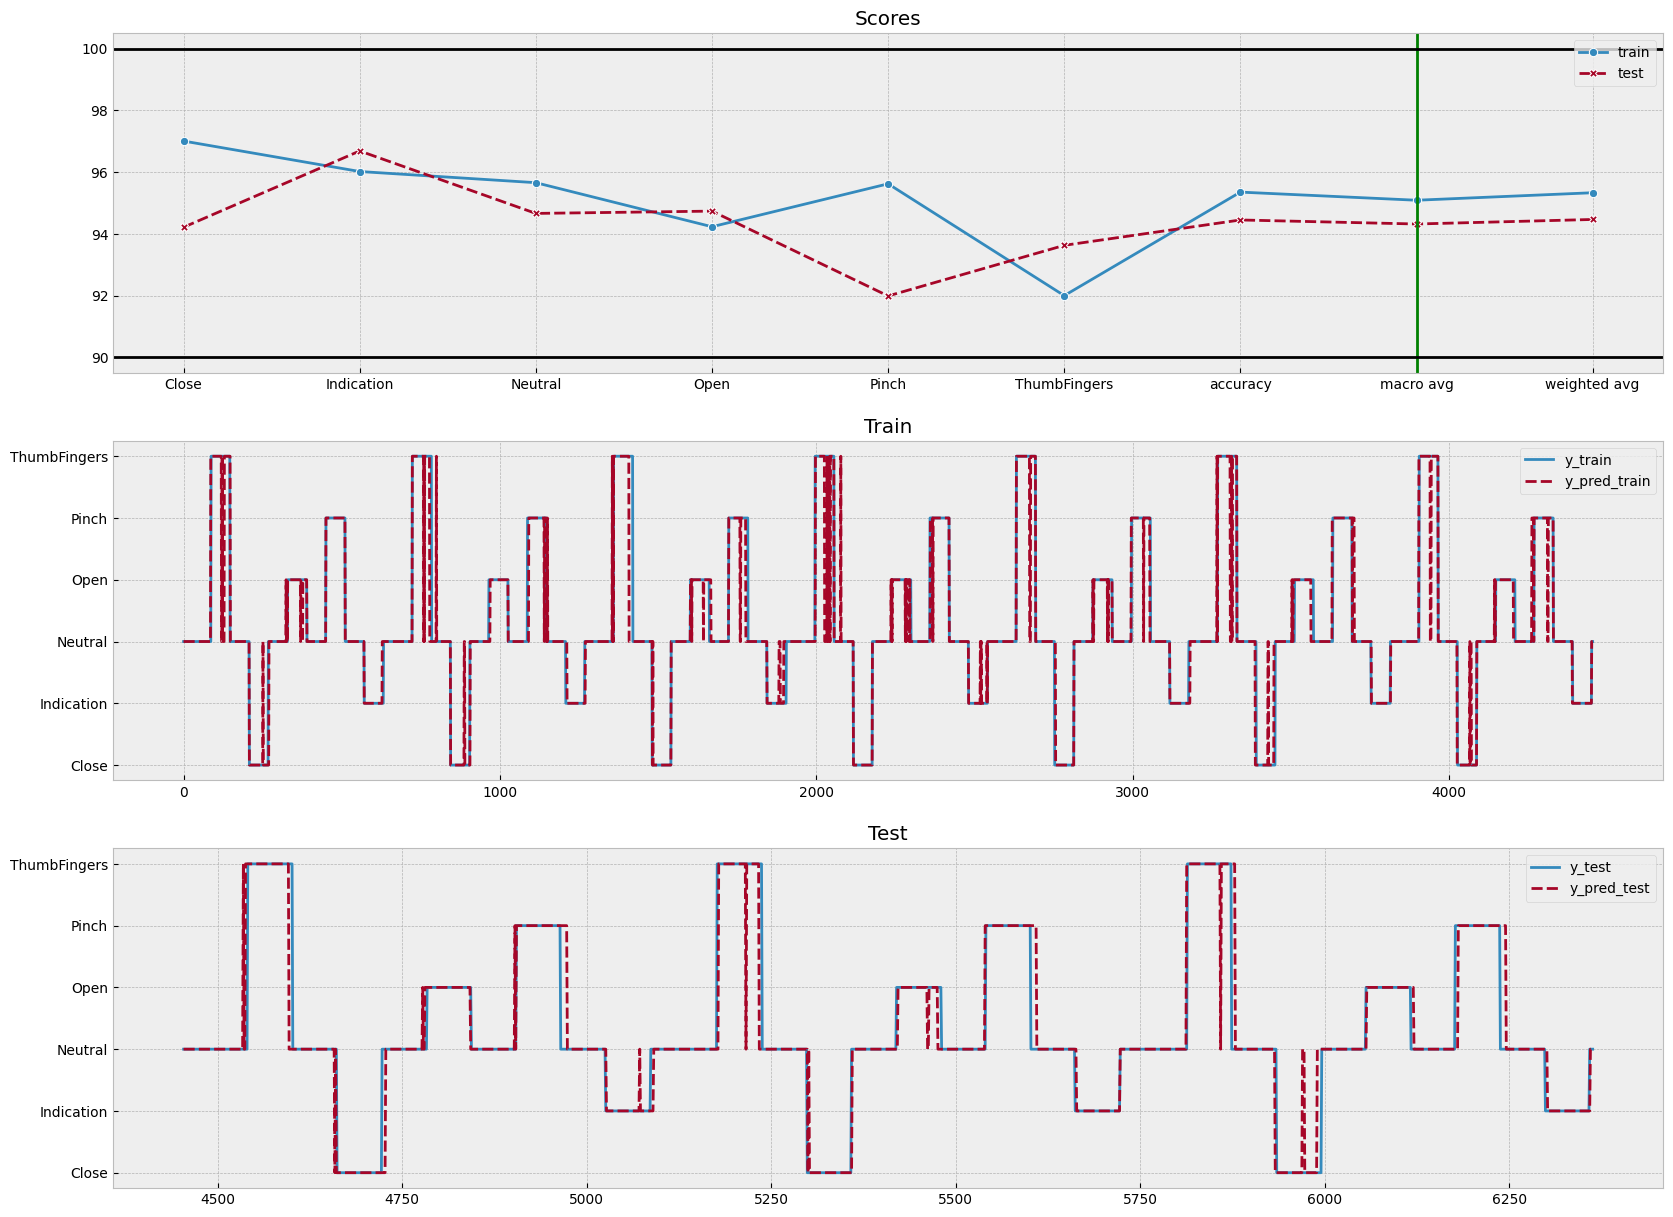

In [31]:
model.set_params(**knn_study.best_params)
model.fit(X_train_selected, y_train)

model_report(model, Xy_set_2, True)

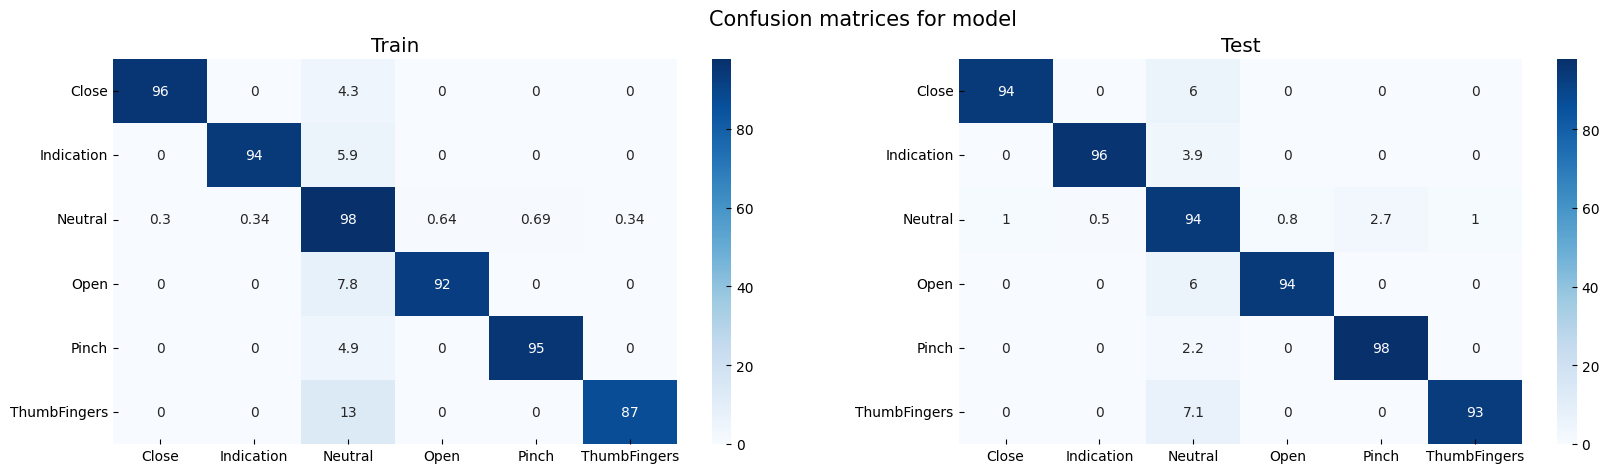

In [32]:
show_confusion_matrix(model, Xy_set_2)

In [33]:
joblib.dump(model, 'models/KNeighbors_model.pkl')

print(joblib.load('models/KNeighbors_model.pkl'))

KNeighborsClassifier(n_neighbors=3, p=6)


# Real-time inference

### Inference Utils: Put your code here

In [34]:
MU = X_train.mean()
SIGMA = X_train.std()


def preprocessing(x):
    X = pd.DataFrame(x, columns=OMG_CH)

    X_sm = smoothe_data(X, best_win)
    X_sc = (X_sm-MU) / SIGMA
    
    y = X_sc[best_features].values
    
    return y


def inference(x, model):
    y = model.predict_proba([x])[0]
    
    return y


def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = (x*0.1) + (prev*0.9) # Holt-Winters filter
        
    return y


def commands(x):
    x_am = x.argmax()
    x_cl = np.clip(x_am/100, 0, 1)
    
    y = np.rint(x_cl*100).astype(int)
    
    return y

### Offline (dataset)

In [35]:
df_sim = gestures.iloc[last_train_i:, :52]

df_sim

,ts,td,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
4454,243374.0,33.0,222.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,213.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4455,243407.0,33.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4456,243440.0,33.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,172.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4457,243473.0,33.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,155.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4458,243506.0,33.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6359,306239.0,33.0,372.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,359.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,10.0
6360,306272.0,33.0,334.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,323.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0
6361,306305.0,33.0,301.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,291.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
6362,306338.0,33.0,270.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,261.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


In [36]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0
y_previous = None

y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}


while True:    
    # [Data reading]
    ts_start = time.time()
    
    try:
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break

        [[ts, cycle_ts], omg_sample] = np.array_split(sample, [2])
        
    except Exception as e:
        print(e)
        
        
    # [Data preprocessing]
    y_dct['omg_sample'].append(omg_sample)
    sample_preprocessed = preprocessing(y_dct['omg_sample'][-10:])[-1]
    
    # [Inference]
    y_predicted = inference(sample_preprocessed, model)
    
    # [Inference Postprocessing]
    y_postprocessed = postprocessing(y_predicted, y_previous)
    
    # [Commands composition]
    y_commands = commands(y_postprocessed)
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION

    
    # [Data logging]
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=52, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        # print('INPUT:\n', s)
        print('SAMPLE:\n', sample)

        # sanity check: Sizes of SAMPLE=65, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
        print(y_postprocessed)
        print(y_commands)
    
    
    ts_diff = time.time() - ts_start
    assert ts_diff < TIMEOUT, 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 
    
    
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (1910, 50)
sample_preprocessed.shape = (1910, 22)
y_predicted.shape = (1910, 6)
y_postprocessed.shape = (1910, 6)
y_commands.shape = (1910,)


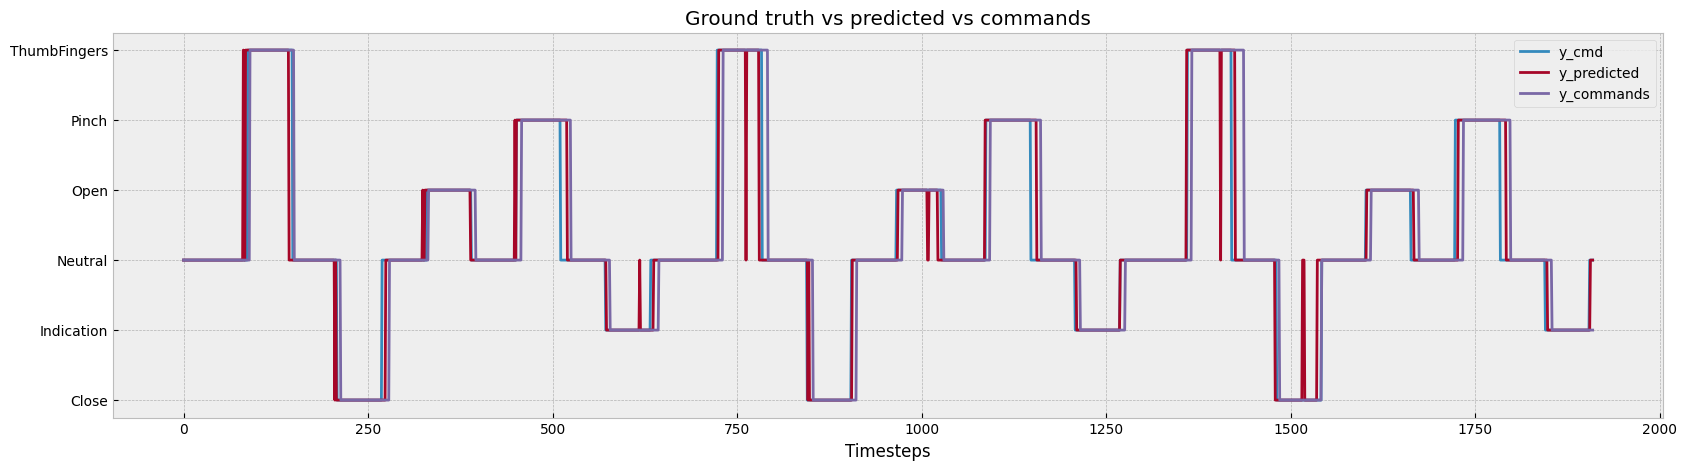

In [37]:
plt.figure(figsize=(20, 5))

sns.lineplot(y_test.values, color='C0', label='y_cmd')
sns.lineplot(y_dct['y_predicted'].argmax(axis=1), color='C1', label='y_predicted')
#sns.lineplot(y_dct['y_postprocessed'].argmax(axis=1), color='C2', label='y_postprocessed')
sns.lineplot(y_dct['y_commands'], color='C2', label='y_commands')

plt.xlabel('Timesteps')
plt.yticks(range(NUM_G), GESTURES)
plt.title('Ground truth vs predicted vs commands')

plt.show()

In [38]:
print(m.classification_report(y_test, y_dct['y_commands'], target_names=GESTURES)) 

              precision    recall  f1-score   support

       Close       0.91      0.91      0.91       182
  Indication       0.87      0.88      0.88       182
     Neutral       0.90      0.87      0.89      1000
        Open       0.89      0.91      0.90       182
       Pinch       0.79      0.87      0.83       182
ThumbFingers       0.86      0.91      0.88       182

    accuracy                           0.88      1910
   macro avg       0.87      0.89      0.88      1910
weighted avg       0.88      0.88      0.88      1910



### Online (prosthesis or virtual hand)

In [39]:
!ls /dev/ttyUSB* 

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [40]:
TIMEOUT = 0.033
DEBUG = True

ser = None
ser_port = None
ser_port = '/dev/ttyUSB1'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, baudrate=115200, timeout=1.0)
    # time.sleep(0.2)

    # ser.write('M0\r\n'.encode())
    # time.sleep(0.1)

    # # ser.write('S2\r\n'.encode())
    # # time.sleep(0.1)

    # ser.write('PT\r\n'.encode())
    # time.sleep(0.1)
    # ser.write('Pt\r\n'.encode())
    # time.sleep(0.1)
    # ser.flush()

    # time.sleep(0.1)

AttributeError: module 'serial' has no attribute 'Serial'

In [ ]:
def parseline():
    line = ser.readline().decode().replace('\n', '')
    data = np.array(list(filter(len, np.array(line.split(" "))))).astype(float)
    return data

ser.readline()
while True:
    data = parseline()
    print(f"data len: {len(data)} |", list(data), end = '                                          \r')

In [ ]:
# flush buffers
ser.reset_input_buffer()
ser.read()

i = 0;
while(ser.in_waiting):
    print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
    ser.read_all()
    time.sleep(0.005)
    i+=1;
ser.readline()
ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

ts_diffs = []
x_previous = None
y_previous = None

pack = None

prev_state = 'None'
prev_idx = -1
y_commands = vp.neutral_state.copy()

while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = s.decode().replace('\n', '')
        data = np.array(list(filter(len, np.array(sample.split(" "))))).astype(float)
        [[ts, cycle_ts], omg_sample] = np.array_split(data, [2])
        
    except Exception as e:
        print(e)
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed.argmax())
    # [/Commands composition]
    
    # [Commands sending]
    # pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    prot_idx = deepcopy(y_commands)
    if (prot_idx!=prev_idx):
        # socket_send(row.Command)
        vp.send_cmd(**y_commands)
        prev_idx = prot_idx
    # [/Commands sending]
    
    y_previous = y_postprocessed

    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        # print('INPUT:\n', s)
        print('SAMPLE:\n', sample)

        # sanity check: Sizes of SAMPLE=65, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
        print(y_postprocessed, GESTURES[y_postprocessed])
        # print(y_commands)
        # print(pack)
    
    ts_diff = time.time() - ts_start
    # assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

# Draft

In [ ]:
# crc_table = [
#     54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
#     111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
#     113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
#     179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
#     115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
#     88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
#     97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
#     45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
#     153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
#     114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
#     215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
#     0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
#     18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
#     57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
#     193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
#     213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
#     137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
#     67, 112, 109, 78, 114, 165, 244, 183, 121
# ];
    
# def get_crc(data, count):
#     result = 0x00
#     l = count
#     while (count>0):   
#         result = crc_table[result ^ data[l-count]]
#         count -= 1;
#     return result;

# def drv_abs_one(ser, control):
#     if ser is None:
#         return
#     pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
#     pack[-1] = get_crc(pack[1:], 9)
#     return (pack, ser.write(bytearray(pack)))

In [ ]:
'''
def commands(x):
    cmd = vp.neutral_state.copy()
    # for this mapping look at GESTURES
    if x == 0: # 'Close'
        cmd.update({'thumb_flex': 1, 'index_flex': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
        return cmd
    elif x == 1: # 'Indication'
        cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
        return cmd
    elif x == 2: # 'Neutral'
        pass
        return cmd
    elif x == 3: # 'Open'
        cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    elif x == 4: # 'Pinch'
        cmd.update({'thumb_flex':1, 'index_flex': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    elif x == 5: # 'ThumbFingers'
        cmd.update({'thumb_flex': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    else:
        return cmd
'''